In [1]:
%pip install pulp          # 최적화 모델링
%pip install numpy         # 수치 계산
%pip install scipy         # 과학 계산
%pip install matplotlib    # 시각화
%pip install geopandas     # 공간 데이터 처리

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pulp
import numpy as np
from scipy.spatial import distance_matrix

def basic_mclp(demand_points, candidate_sites, num_facilities, service_radius):
    """
    기본 MCLP 구현체
    [입력]
    demand_points: 수요지 좌표 (N x 2 배열)
    candidate_sites: 후보지 좌표 (M x 2 배열)
    num_facilities: 설치할 시설 개수
    service_radius: 서비스 반경
    """
    # 거리 행렬 계산
    dist_matrix = distance_matrix(demand_points, candidate_sites)
    coverage = (dist_matrix <= service_radius).astype(int)

    # 최적화 문제 정의
    prob = pulp.LpProblem("Basic_MCLP", pulp.LpMaximize)
    
    # 의사결정 변수
    x = pulp.LpVariable.dicts("x", range(len(candidate_sites)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_points)), cat='Binary')
    
    # 목적함수: 최대 커버리지
    prob += pulp.lpSum(y[i] for i in range(len(demand_points)))
    
    # 제약조건
    prob += pulp.lpSum(x[j] for j in range(len(candidate_sites))) == num_facilities
    
    for i in range(len(demand_points)):
        prob += y[i] <= pulp.lpSum(x[j] * coverage[i,j] 
                                 for j in range(len(candidate_sites)))
    
    # 문제 풀이
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # 결과 처리
    selected = [j for j in range(len(candidate_sites)) if x[j].varValue == 1]
    covered = [i for i in range(len(demand_points)) if y[i].varValue == 1]
    
    return selected, covered

# 기본 실행 예시
if __name__ == "__main__":
    # 테스트 데이터 생성
    np.random.seed(0)
    demand = np.random.rand(50, 2) * 1000  # 50개 수요지
    candidates = np.random.rand(20, 2) * 1000  # 20개 후보지
    
    # 최적화 실행
    selected_sites, covered_demand = basic_mclp(
        demand_points=demand,
        candidate_sites=candidates,
        num_facilities=5,
        service_radius=200
    )
    
    print(f"선정된 후보지: {selected_sites}")
    print(f"커버된 수요지: {len(covered_demand)}/{len(demand)}")


선정된 후보지: [2, 5, 11, 16, 19]
커버된 수요지: 29/50


In [3]:
import matplotlib.pyplot as plt

def visualize_results(demand, candidates, selected, coverage, service_radius):
    """결과 시각화"""
    plt.figure(figsize=(10,6))
    
    # 수요지: 파란색
    plt.scatter(demand[:,0], demand[:,1], c='blue', 
                label=f'Demand ({len(demand)} points)')
    
    # 후보지: 빨간색 X
    plt.scatter(candidates[:,0], candidates[:,1], 
                c='red', marker='x', label='Candidates')
    
    # 선정된 후보지: 초록색 원
    selected_points = candidates[selected]
    plt.scatter(selected_points[:,0], selected_points[:,1],
                c='green', s=100, label='Selected Sites')
    
    # 서비스 반경 표시
    for j in selected:
        circle = plt.Circle(candidates[j], service_radius, 
                          color='green', fill=False, alpha=0.3)
        plt.gca().add_patch(circle)
    
    plt.legend()
    plt.title("MCLP Optimization Results")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()


In [4]:
def weighted_mclp(demand_points, demand_weights, candidate_sites, 
                num_facilities, service_radius):
    """가중치를 고려한 MCLP"""
    dist_matrix = distance_matrix(demand_points, candidate_sites)
    coverage = (dist_matrix <= service_radius).astype(int)
    
    prob = pulp.LpProblem("Weighted_MCLP", pulp.LpMaximize)
    
    x = pulp.LpVariable.dicts("x", range(len(candidate_sites)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_points)), cat='Binary')
    
    # 가중치 반영 목적함수
    prob += pulp.lpSum(y[i] * demand_weights[i] 
                      for i in range(len(demand_points)))
    
    prob += pulp.lpSum(x[j] for j in range(len(candidate_sites))) == num_facilities
    
    for i in range(len(demand_points)):
        prob += y[i] <= pulp.lpSum(x[j] * coverage[i,j] 
                                 for j in range(len(candidate_sites)))
    
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    selected = [j for j in range(len(candidate_sites)) if x[j].varValue == 1]
    covered = [i for i in range(len(demand_points)) if y[i].varValue == 1]
    
    return selected, covered


In [5]:
def mclp_with_existing(demand_points, candidate_sites, existing_sites,
                      num_facilities, service_radius, min_distance):
    """기존 시설과의 최소 거리 유지"""
    # 기존 시설과 후보지 간 거리 계산
    existing_dist = distance_matrix(candidate_sites, existing_sites)
    valid_candidates = np.all(existing_dist >= min_distance, axis=1)
    
    # 유효한 후보지만 선택
    filtered_candidates = candidate_sites[valid_candidates]
    
    # 기본 MCLP 실행
    selected, covered = basic_mclp(
        demand_points=demand_points,
        candidate_sites=filtered_candidates,
        num_facilities=num_facilities,
        service_radius=service_radius
    )
    
    # 원본 인덱스로 변환
    original_indices = np.where(valid_candidates)[0][selected]
    
    return original_indices.tolist(), covered


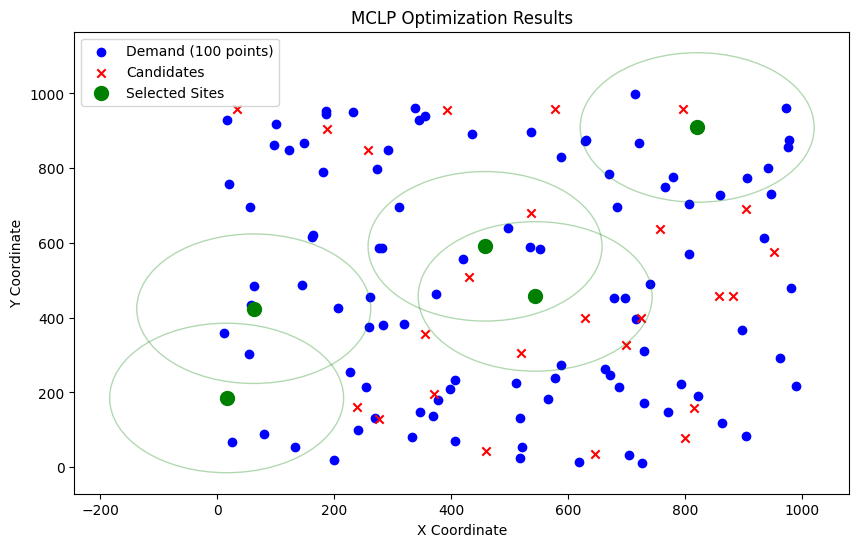

In [6]:
if __name__ == "__main__":
    # 데이터 준비
    demand = np.random.rand(100, 2) * 1000  # 100개 수요지
    candidates = np.random.rand(30, 2) * 1000  # 30개 후보지
    existing = np.random.rand(5, 2) * 1000  # 5개 기존 시설
    
    # 5단계 기능 실행
    selected, covered = mclp_with_existing(
        demand_points=demand,
        candidate_sites=candidates,
        existing_sites=existing,
        num_facilities=5,
        service_radius=200,
        min_distance=300  # 기존 시설과 300m 이상 거리 유지
    )
    
    # 시각화
    visualize_results(demand, candidates, selected, covered, 200)


In [3]:
# mac에서
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')  # 애플고딕 사용
plt.rcParams['axes.unicode_minus'] = False

# windows에서
# import matplotlib.pyplot as plt
# plt.rc('font', family='Malgun Gothic')  # 맑은 고딕 사용
# plt.rcParams['axes.unicode_minus'] = False


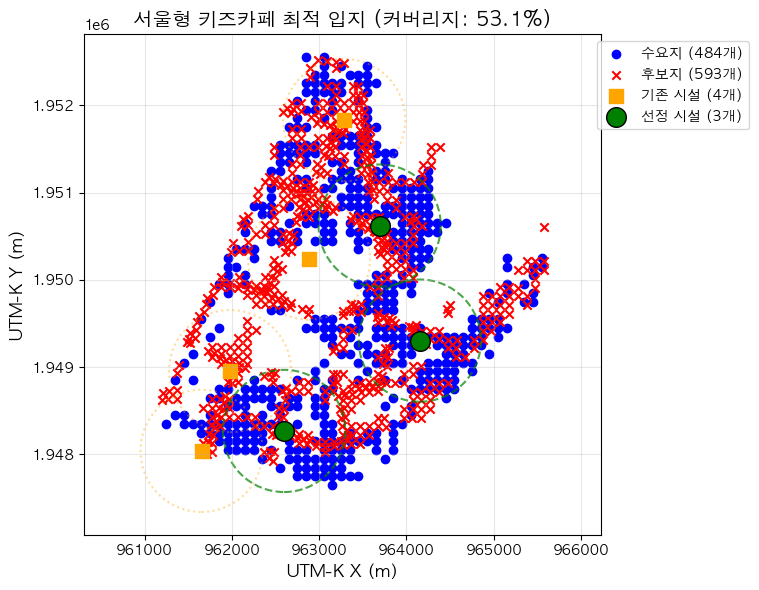

◆◆◆ 최적 입지 좌표 (UTM-K) ◆◆◆
[1] X: 962597.77, Y: 1948268.79
[2] X: 963692.80, Y: 1950621.43
[3] X: 964153.53, Y: 1949303.57


In [4]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer

# 좌표계 변환기 생성 (WGS84 → UTM-K)
transformer = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

# 1. 데이터 불러오기 및 좌표 변환
def load_and_convert(file_path):
    df = pd.read_csv(file_path)
    x, y = transformer.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y])

demand_coords = load_and_convert('suyo2.csv')
candidate_coords = load_and_convert('hubo2.csv')
existing_coords = load_and_convert('kidscafes.csv')

# 2. MCLP 최적화 함수 (UTM-K 좌표 기반)
def mclp_with_coords_utm(demand_coords, candidate_coords, num_facilities, service_radius_m,
                        existing_coords=None, min_distance_m=0):
    # 기존 시설 거리 필터링
    if existing_coords is not None and min_distance_m > 0:
        dist_to_existing = distance_matrix(candidate_coords, existing_coords)
        valid_mask = np.all(dist_to_existing >= min_distance_m, axis=1)
        candidate_coords = candidate_coords[valid_mask]
        print(f"필터링 후 유효 후보지: {len(candidate_coords)}개")
    
    # 커버리지 행렬 계산
    dist_matrix = distance_matrix(demand_coords, candidate_coords)
    coverage = (dist_matrix <= service_radius_m).astype(int)
    
    # 최적화 모델
    prob = pulp.LpProblem("MCLP_UTM", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(len(candidate_coords)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_coords)), cat='Binary')
    
    prob += pulp.lpSum(y)
    prob += pulp.lpSum(x) == num_facilities
    for i in range(len(demand_coords)):
        prob += y[i] <= pulp.lpSum(x[j] * coverage[i,j] for j in range(len(candidate_coords)))
    
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    selected = [j for j in range(len(candidate_coords)) if x[j].varValue == 1]
    covered = [i for i in range(len(demand_coords)) if y[i].varValue == 1]
    
    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(demand_coords[:,0], demand_coords[:,1], c='blue', label=f'수요지 ({len(demand_coords)}개)')
    plt.scatter(candidate_coords[:,0], candidate_coords[:,1], c='red', marker='x', label=f'후보지 ({len(candidate_coords)}개)')
    
    if existing_coords is not None:
        plt.scatter(existing_coords[:,0], existing_coords[:,1], 
                    c='orange', s=100, marker='s', label=f'기존 시설 ({len(existing_coords)}개)')
     
     # 기존 시설 반경 추가
    for site in existing_coords:
        circle = plt.Circle(
            (site[0], site[1]), 
            service_radius_m, 
            color='orange', 
            fill=False, 
            linestyle=':', 
            linewidth=1.5, 
            alpha=0.4
        )
        plt.gca().add_patch(circle)

    selected_sites = candidate_coords[selected]
    plt.scatter(selected_sites[:,0], selected_sites[:,1], 
                c='green', s=200, edgecolor='black', label=f'선정 시설 ({len(selected)}개)')
    
    # 서비스 반경 원 추가
    for site in selected_sites:
        circle = plt.Circle((site[0], site[1]), service_radius_m, 
                           color='green', fill=False, linestyle='--', linewidth=1.5, alpha=0.7)
        plt.gca().add_patch(circle)
    
    # 축 설정
    plt.title(f'서울형 키즈카페 최적 입지 (커버리지: {len(covered)/len(demand_coords):.1%})', fontsize=14)
    plt.xlabel('UTM-K X (m)', fontsize=12)
    plt.ylabel('UTM-K Y (m)', fontsize=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 결과 출력
    print("◆◆◆ 최적 입지 좌표 (UTM-K) ◆◆◆")
    for idx, (x, y) in enumerate(selected_sites, 1):
        print(f"[{idx}] X: {x:.2f}, Y: {y:.2f}")
    
    return selected_sites, covered

# 3. 실행 (700m 서비스 반경)
selected, covered = mclp_with_coords_utm(
    demand_coords=demand_coords,
    candidate_coords=candidate_coords,
    num_facilities=3,
    service_radius_m=700,  # 미터 단위
    existing_coords=existing_coords,
    min_distance_m=0
)


In [2]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv('score_top_27.csv')

# 중심 좌표 계산: left, right, top, bottom 컬럼 사용
df['x'] = (df['left'] + df['right']) / 2
df['y'] = (df['top'] + df['bottom']) / 2

# x, y 컬럼만 추출
df_out = df[['x', 'y']]

# 저장
df_out.to_csv('candidate_sites.csv', index=False, encoding='utf-8-sig')

print(df_out.head())
print("후보지 좌표 파일이 'candidate_sites.csv'로 저장되었습니다.")


               x              y
0  205347.012836  448624.456345
1  205347.012836  448524.456345
2  205447.012836  448624.456345
3  205447.012836  448524.456345
4  205547.012836  448924.456345
후보지 좌표 파일이 'candidate_sites.csv'로 저장되었습니다.


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0b/q86cgv097fd6gwqv24m4fg1c0000gn/T/f5f7fef333b5476f909216f37a85bcf3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0b/q86cgv097fd6gwqv24m4fg1c0000gn/T/f5f7fef333b5476f909216f37a85bcf3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 490 COLUMNS
At line 35528 RHS
At line 36014 BOUNDS
At line 37092 ENDATA
Problem MODEL has 485 rows, 1077 columns and 32399 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 384 - 0.02 seconds
Cgl0004I processed model has 324 rows, 804 columns (804 integer (756 of which binary)) and 19229 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found 

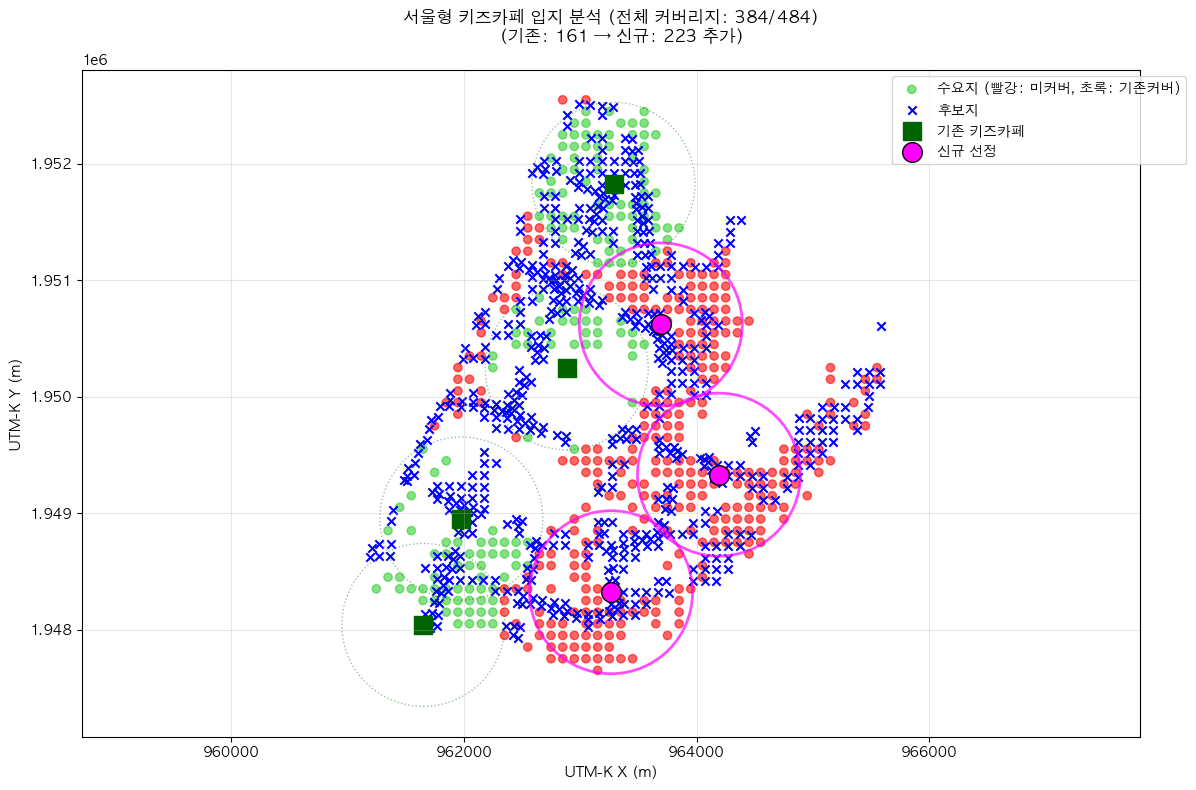

In [5]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer

# 좌표계 변환기 (WGS84 → UTM-K)
transformer = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

def load_and_convert(file_path):
    df = pd.read_csv(file_path)
    x, y = transformer.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y])

# 데이터 로드
demand_coords = load_and_convert('suyo2.csv')
candidate_coords = load_and_convert('hubo2.csv')
existing_coords = load_and_convert('kidscafes.csv')

def advanced_mclp(demand, candidates, existing, num_new, radius):
    """개선된 MCLP: 기존 시설 커버리지 포함"""
    
    # 1. 기존 시설 커버리지 계산
    if existing is not None:
        dist_existing = distance_matrix(demand, existing)
        existing_cover = (dist_existing <= radius).any(axis=1).astype(int)
    else:
        existing_cover = np.zeros(len(demand), dtype=int)
    
    # 2. 후보지 커버리지 계산
    dist_candidate = distance_matrix(demand, candidates)
    candidate_cover = (dist_candidate <= radius).astype(int)
    
    # 3. 최적화 모델링
    prob = pulp.LpProblem("Advanced_MCLP", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(len(candidates)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand)), cat='Binary')
    
    # 목적함수: 총 커버리지 최대화
    prob += pulp.lpSum(y)
    
    # 제약조건
    prob += pulp.lpSum(x) == num_new  # 신규 시설 수
    for i in range(len(demand)):
        # y[i] <= (기존 커버) OR (신규 커버)
        prob += y[i] <= existing_cover[i] + pulp.lpSum(x[j]*candidate_cover[i,j] for j in range(len(candidates)))
    
    # 최적화 실행
    prob.solve()
    
    # 4. 결과 처리
    selected = [j for j in range(len(candidates)) if x[j].varValue == 1]
    covered = [i for i in range(len(demand)) if y[i].varValue == 1]
    
    return selected, covered, existing_cover

# 최적화 실행
selected_idx, covered_idx, existing_covered = advanced_mclp(
    demand_coords, candidate_coords, existing_coords, 
    num_new=3, radius=700
)

# 시각화
plt.figure(figsize=(12, 8))

# 수요지 색상 분류
colors = ['red' if ec == 0 else 'limegreen' for ec in existing_covered]
plt.scatter(demand_coords[:,0], demand_coords[:,1], c=colors, 
            label='수요지 (빨강: 미커버, 초록: 기존커버)', alpha=0.6)

# 후보지
plt.scatter(candidate_coords[:,0], candidate_coords[:,1], 
            c='blue', marker='x', label='후보지')

# 기존 시설 + 서비스 영역
if existing_coords is not None:
    plt.scatter(existing_coords[:,0], existing_coords[:,1], 
                c='darkgreen', s=150, marker='s', label='기존 키즈카페')
    for site in existing_coords:
        circle = plt.Circle(site, 700, color='darkgreen', 
                           fill=False, linestyle=':', linewidth=1, alpha=0.4)
        plt.gca().add_patch(circle)

# 선정된 신규 시설 + 서비스 영역
selected_sites = candidate_coords[selected_idx]
plt.scatter(selected_sites[:,0], selected_sites[:,1], 
            c='magenta', s=200, edgecolor='black', label='신규 선정')
for site in selected_sites:
    circle = plt.Circle(site, 700, color='magenta', 
                       fill=False, linewidth=2, alpha=0.7)
    plt.gca().add_patch(circle)

# 커버리지 계산
total_covered = len(covered_idx)
existing_only = sum(existing_covered)
new_covered = total_covered - existing_only

plt.title(
    f'''서울형 키즈카페 입지 분석 (전체 커버리지: {total_covered}/{len(demand_coords)})
    (기존: {existing_only} → 신규: {new_covered} 추가)''', 
    pad=20
)
plt.xlabel('UTM-K X (m)')
plt.ylabel('UTM-K Y (m)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()


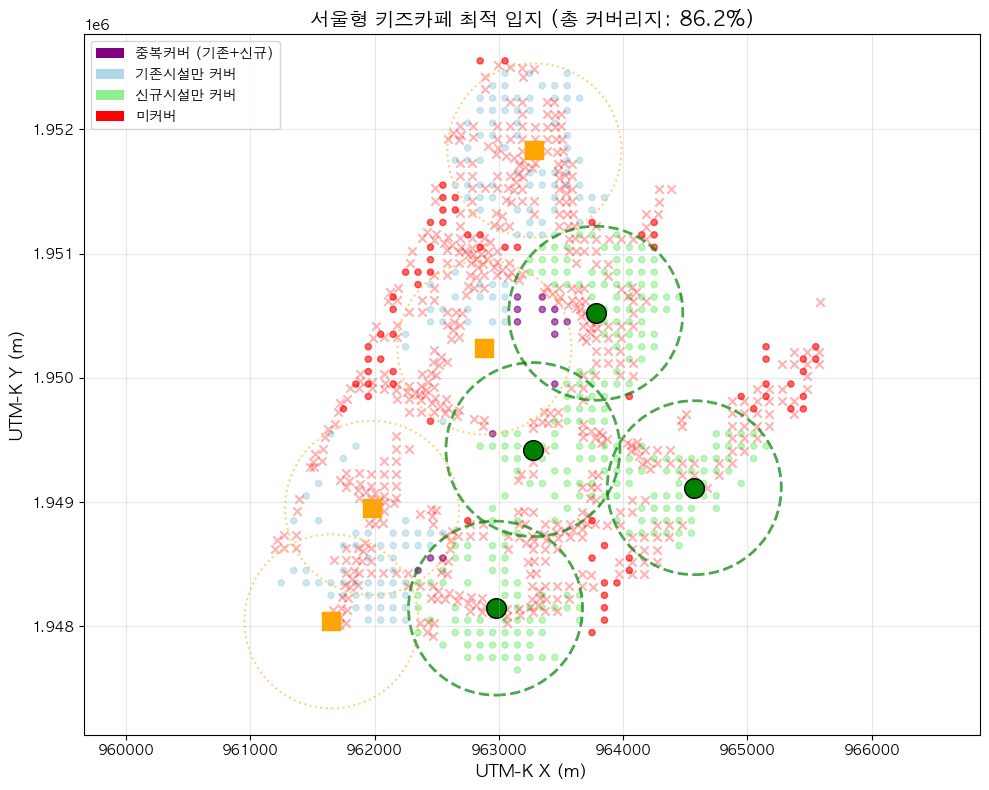

◆◆◆ 커버리지 분석 결과 ◆◆◆
기존 시설 커버: 161개 (33.3%)
신규 추가 커버: 256개 (52.9%)
중복 커버: 14개 (2.9%)
총 커버리지: 417개 (86.2%)
미커버: 67개 (13.8%)
◆◆◆ 선정된 신규 시설 좌표 ◆◆◆
[1] X: 962973.37, Y: 1948146.79
[2] X: 963274.50, Y: 1949422.58
[3] X: 963780.15, Y: 1950519.49
[4] X: 964572.39, Y: 1949115.79


In [8]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer

# 좌표계 변환기 생성 (WGS84 → UTM-K)
transformer = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

# 1. 데이터 불러오기 및 좌표 변환
def load_and_convert(file_path):
    df = pd.read_csv(file_path)
    x, y = transformer.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y])

demand_coords = load_and_convert('suyo2.csv')
candidate_coords = load_and_convert('hubo2.csv')
existing_coords = load_and_convert('kidscafes.csv')

# 2. 개선된 MCLP 함수 (기존 + 신규 총 커버리지 계산)
def mclp_total_coverage(demand_coords, candidate_coords, num_facilities, service_radius_m,
                       existing_coords=None, min_distance_m=0):
    
    # 1단계: 기존 시설 커버리지 계산
    existing_covered = np.zeros(len(demand_coords), dtype=bool)
    if existing_coords is not None and len(existing_coords) > 0:
        dist_existing = distance_matrix(demand_coords, existing_coords)
        existing_covered = (dist_existing <= service_radius_m).any(axis=1)
    
    # 2단계: 후보지 필터링 (기존 시설과의 거리 제약)
    valid_candidates = candidate_coords.copy()
    if existing_coords is not None and min_distance_m > 0:
        dist_to_existing = distance_matrix(candidate_coords, existing_coords)
        valid_mask = np.all(dist_to_existing >= min_distance_m, axis=1)
        valid_candidates = candidate_coords[valid_mask]
        print(f"필터링 후 유효 후보지: {len(valid_candidates)}개")
    
    # 3단계: 신규 시설 최적화 (기존 미커버 지역 우선)
    dist_matrix = distance_matrix(demand_coords, valid_candidates)
    coverage = (dist_matrix <= service_radius_m).astype(int)
    
    # 최적화 모델
    prob = pulp.LpProblem("MCLP_Total_Coverage", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(len(valid_candidates)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_coords)), cat='Binary')
    
    # 목적함수: 기존 시설로 커버되지 않은 수요지 우선 커버
    prob += pulp.lpSum(y[i] * (1 - existing_covered[i]) for i in range(len(demand_coords)))
    
    # 제약조건
    prob += pulp.lpSum(x[j] for j in range(len(valid_candidates))) == num_facilities
    for i in range(len(demand_coords)):
        prob += y[i] <= pulp.lpSum(x[j] * coverage[i,j] for j in range(len(valid_candidates)))
    
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # 4단계: 결과 분석
    selected = [j for j in range(len(valid_candidates)) if x[j].varValue == 1]
    selected_sites = valid_candidates[selected]
    
    # 신규 시설 커버리지 계산
    new_covered = np.zeros(len(demand_coords), dtype=bool)
    if len(selected_sites) > 0:
        dist_new = distance_matrix(demand_coords, selected_sites)
        new_covered = (dist_new <= service_radius_m).any(axis=1)
    
    # 총 커버리지 = 기존 커버 OR 신규 커버
    total_covered = existing_covered | new_covered
    
    # 커버리지 통계
    existing_count = np.sum(existing_covered)
    new_only_count = np.sum(new_covered & ~existing_covered)  # 신규로만 커버되는 수요지
    total_count = np.sum(total_covered)
    overlap_count = np.sum(existing_covered & new_covered)  # 중복 커버
    
    # 5단계: 시각화
    plt.figure(figsize=(10, 8))
    
    # 수요지 색상 구분
    colors = []
    for i in range(len(demand_coords)):
        if existing_covered[i] and new_covered[i]:
            colors.append('purple')  # 기존+신규 중복 커버
        elif existing_covered[i]:
            colors.append('lightblue')  # 기존만 커버
        elif new_covered[i]:
            colors.append('lightgreen')  # 신규만 커버
        else:
            colors.append('red')  # 미커버
    
    plt.scatter(demand_coords[:,0], demand_coords[:,1], c=colors, alpha=0.6, s=20,
                label=f'수요지 ({len(demand_coords)}개)')
    
    # 후보지
    plt.scatter(candidate_coords[:,0], candidate_coords[:,1], c='red', marker='x', 
                alpha=0.3, label=f'후보지 ({len(candidate_coords)}개)')
    
    # 기존 시설 + 서비스 영역
    if existing_coords is not None:
        plt.scatter(existing_coords[:,0], existing_coords[:,1], 
                    c='orange', s=150, marker='s', label=f'기존 시설 ({len(existing_coords)}개)')
        for site in existing_coords:
            circle = plt.Circle(site, service_radius_m, color='orange', 
                               fill=False, linestyle=':', linewidth=1.5, alpha=0.5)
            plt.gca().add_patch(circle)
    
    # 선정된 신규 시설 + 서비스 영역
    plt.scatter(selected_sites[:,0], selected_sites[:,1], 
                c='green', s=200, edgecolor='black', label=f'선정 시설 ({len(selected)}개)')
    for site in selected_sites:
        circle = plt.Circle(site, service_radius_m, color='green', 
                           fill=False, linestyle='--', linewidth=2, alpha=0.7)
        plt.gca().add_patch(circle)
    
    # 범례 추가 (수요지 색상 설명)
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='purple', label='중복커버 (기존+신규)'),
        Patch(facecolor='lightblue', label='기존시설만 커버'),  
        Patch(facecolor='lightgreen', label='신규시설만 커버'),
        Patch(facecolor='red', label='미커버')
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    # 제목과 축 설정
    total_coverage_pct = total_count / len(demand_coords) * 100
    plt.title(f'서울형 키즈카페 최적 입지 (총 커버리지: {total_coverage_pct:.1f}%)', fontsize=14)
    plt.xlabel('UTM-K X (m)', fontsize=12)
    plt.ylabel('UTM-K Y (m)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 6단계: 상세 결과 출력
    print("=" * 50)
    print("◆◆◆ 커버리지 분석 결과 ◆◆◆")
    print(f"기존 시설 커버: {existing_count}개 ({existing_count/len(demand_coords)*100:.1f}%)")
    print(f"신규 추가 커버: {new_only_count}개 ({new_only_count/len(demand_coords)*100:.1f}%)")
    print(f"중복 커버: {overlap_count}개 ({overlap_count/len(demand_coords)*100:.1f}%)")
    print(f"총 커버리지: {total_count}개 ({total_coverage_pct:.1f}%)")
    print(f"미커버: {len(demand_coords) - total_count}개 ({(len(demand_coords) - total_count)/len(demand_coords)*100:.1f}%)")
    print("=" * 50)
    
    print("◆◆◆ 선정된 신규 시설 좌표 ◆◆◆")
    for idx, (x, y) in enumerate(selected_sites, 1):
        print(f"[{idx}] X: {x:.2f}, Y: {y:.2f}")
    
    return {
        'selected_sites': selected_sites,
        'total_coverage': total_coverage_pct,
        'existing_coverage': existing_count/len(demand_coords)*100,
        'new_coverage': new_only_count/len(demand_coords)*100,
        'overlap_coverage': overlap_count/len(demand_coords)*100
    }

# 3. 실행
result = mclp_total_coverage(
    demand_coords=demand_coords,
    candidate_coords=candidate_coords,
    num_facilities=3,
    service_radius_m=700,
    existing_coords=existing_coords,
    min_distance_m=0
)


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


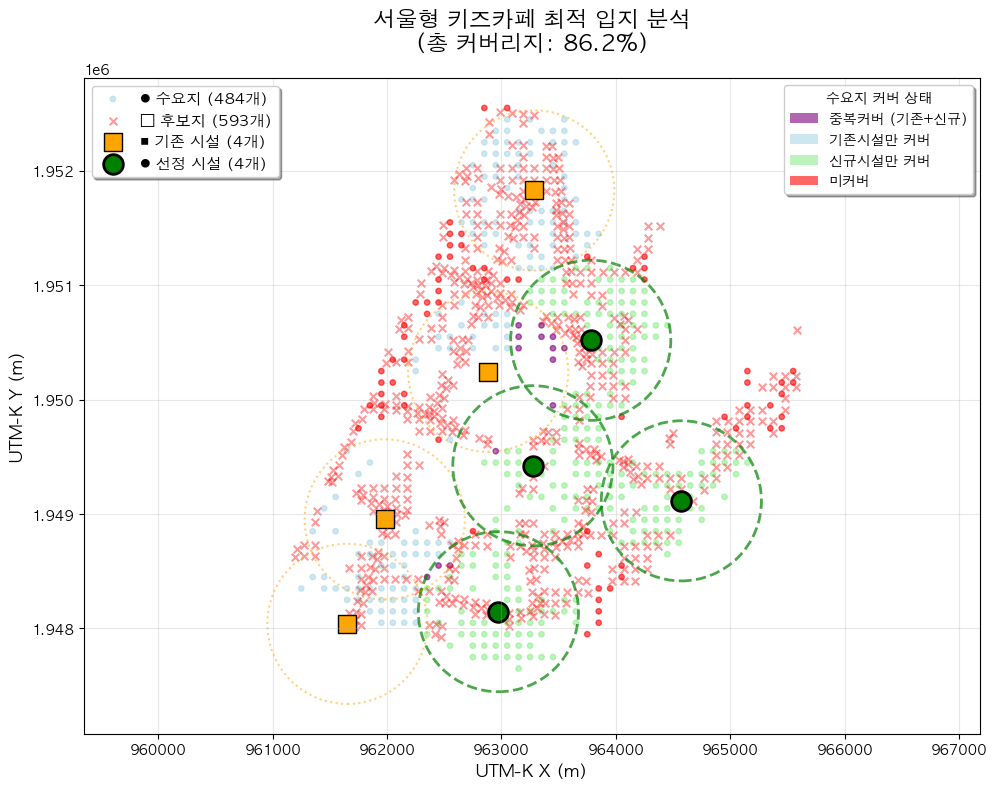

◆◆◆ 데이터 현황 ◆◆◆
수요지: 484개
후보지: 593개
기존 시설: 4개
선정 시설: 4개
◆◆◆ 커버리지 분석 결과 ◆◆◆
기존 시설 커버: 161개 (33.3%)
신규 추가 커버: 256개 (52.9%)
중복 커버: 14개 (2.9%)
총 커버리지: 417개 (86.2%)
미커버: 67개 (13.8%)
◆◆◆ 선정된 신규 시설 좌표 ◆◆◆
[1] X: 962973.37, Y: 1948146.79
[2] X: 963274.50, Y: 1949422.58
[3] X: 963780.15, Y: 1950519.49
[4] X: 964572.39, Y: 1949115.79


In [13]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer

# 좌표계 변환기 생성 (WGS84 → UTM-K)
transformer = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

# 1. 데이터 불러오기 및 좌표 변환
def load_and_convert(file_path):
    df = pd.read_csv(file_path)
    x, y = transformer.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y])

demand_coords = load_and_convert('suyo2.csv')
candidate_coords = load_and_convert('hubo2.csv')
existing_coords = load_and_convert('kidscafes.csv')

# 2. 개선된 MCLP 함수 (기존 + 신규 총 커버리지 계산)
def mclp_total_coverage(demand_coords, candidate_coords, num_facilities, service_radius_m,
                       existing_coords=None, min_distance_m=0):
    
    # 1단계: 기존 시설 커버리지 계산
    existing_covered = np.zeros(len(demand_coords), dtype=bool)
    if existing_coords is not None and len(existing_coords) > 0:
        dist_existing = distance_matrix(demand_coords, existing_coords)
        existing_covered = (dist_existing <= service_radius_m).any(axis=1)
    
    # 2단계: 후보지 필터링 (기존 시설과의 거리 제약)
    valid_candidates = candidate_coords.copy()
    if existing_coords is not None and min_distance_m > 0:
        dist_to_existing = distance_matrix(candidate_coords, existing_coords)
        valid_mask = np.all(dist_to_existing >= min_distance_m, axis=1)
        valid_candidates = candidate_coords[valid_mask]
        print(f"필터링 후 유효 후보지: {len(valid_candidates)}개")
    
    # 3단계: 신규 시설 최적화 (기존 미커버 지역 우선)
    dist_matrix = distance_matrix(demand_coords, valid_candidates)
    coverage = (dist_matrix <= service_radius_m).astype(int)
    
    # 최적화 모델
    prob = pulp.LpProblem("MCLP_Total_Coverage", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(len(valid_candidates)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_coords)), cat='Binary')
    
    # 목적함수: 기존 시설로 커버되지 않은 수요지 우선 커버
    prob += pulp.lpSum(y[i] * (1 - existing_covered[i]) for i in range(len(demand_coords)))
    
    # 제약조건
    prob += pulp.lpSum(x[j] for j in range(len(valid_candidates))) == num_facilities
    for i in range(len(demand_coords)):
        prob += y[i] <= pulp.lpSum(x[j] * coverage[i,j] for j in range(len(valid_candidates)))
    
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # 4단계: 결과 분석
    selected = [j for j in range(len(valid_candidates)) if x[j].varValue == 1]
    selected_sites = valid_candidates[selected]
    
    # 신규 시설 커버리지 계산
    new_covered = np.zeros(len(demand_coords), dtype=bool)
    if len(selected_sites) > 0:
        dist_new = distance_matrix(demand_coords, selected_sites)
        new_covered = (dist_new <= service_radius_m).any(axis=1)
    
    # 총 커버리지 = 기존 커버 OR 신규 커버
    total_covered = existing_covered | new_covered
    
    # 커버리지 통계
    existing_count = np.sum(existing_covered)
    new_only_count = np.sum(new_covered & ~existing_covered)  # 신규로만 커버되는 수요지
    total_count = np.sum(total_covered)
    overlap_count = np.sum(existing_covered & new_covered)  # 중복 커버
    
    # 5단계: 시각화 (개수 표시 개선)
    plt.figure(figsize=(10, 8))
    
    # 수요지 색상 구분
    colors = []
    for i in range(len(demand_coords)):
        if existing_covered[i] and new_covered[i]:
            colors.append('purple')  # 기존+신규 중복 커버
        elif existing_covered[i]:
            colors.append('lightblue')  # 기존만 커버
        elif new_covered[i]:
            colors.append('lightgreen')  # 신규만 커버
        else:
            colors.append('red')  # 미커버
    
    # 각 요소별 플롯 (개수 명시)
    plt.scatter(demand_coords[:,0], demand_coords[:,1], c=colors, alpha=0.6, s=15,
                label=f'● 수요지 ({len(demand_coords)}개)')
    
    plt.scatter(candidate_coords[:,0], candidate_coords[:,1], c='red', marker='x', 
                alpha=0.4, s=30, label=f'✕ 후보지 ({len(candidate_coords)}개)')
    
    # 기존 시설 + 서비스 영역
    if existing_coords is not None:
        plt.scatter(existing_coords[:,0], existing_coords[:,1], 
                    c='orange', s=150, marker='s', edgecolor='black', linewidth=1,
                    label=f'■ 기존 시설 ({len(existing_coords)}개)')
        for site in existing_coords:
            circle = plt.Circle(site, service_radius_m, color='orange', 
                               fill=False, linestyle=':', linewidth=1.5, alpha=0.5)
            plt.gca().add_patch(circle)
    
    # 선정된 신규 시설 + 서비스 영역
    plt.scatter(selected_sites[:,0], selected_sites[:,1], 
                c='green', s=200, marker='o', edgecolor='black', linewidth=2,
                label=f'● 선정 시설 ({len(selected)}개)')
    for site in selected_sites:
        circle = plt.Circle(site, service_radius_m, color='green', 
                           fill=False, linestyle='--', linewidth=2, alpha=0.7)
        plt.gca().add_patch(circle)
    
    # 메인 범례 (시설 타입별)
    main_legend = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), 
                            fontsize=11, frameon=True, fancybox=True, shadow=True)
    
    # 수요지 색상 설명을 위한 추가 범례
    from matplotlib.patches import Patch
    color_legend_elements = [
        Patch(facecolor='purple', alpha=0.6, label='중복커버 (기존+신규)'),
        Patch(facecolor='lightblue', alpha=0.6, label='기존시설만 커버'),  
        Patch(facecolor='lightgreen', alpha=0.6, label='신규시설만 커버'),
        Patch(facecolor='red', alpha=0.6, label='미커버')
    ]
    color_legend = plt.legend(handles=color_legend_elements, loc='upper right', 
                             bbox_to_anchor=(1, 1), title='수요지 커버 상태',
                             fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # 두 범례 모두 표시
    plt.gca().add_artist(main_legend)
    
    # 제목과 축 설정
    total_coverage_pct = total_count / len(demand_coords) * 100
    plt.title(f'서울형 키즈카페 최적 입지 분석\n(총 커버리지: {total_coverage_pct:.1f}%)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('UTM-K X (m)', fontsize=12)
    plt.ylabel('UTM-K Y (m)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 6단계: 상세 결과 출력
    print("=" * 60)
    print("◆◆◆ 데이터 현황 ◆◆◆")
    print(f"수요지: {len(demand_coords)}개")
    print(f"후보지: {len(candidate_coords)}개") 
    print(f"기존 시설: {len(existing_coords) if existing_coords is not None else 0}개")
    print(f"선정 시설: {len(selected)}개")
    print("=" * 60)
    
    print("◆◆◆ 커버리지 분석 결과 ◆◆◆")
    print(f"기존 시설 커버: {existing_count}개 ({existing_count/len(demand_coords)*100:.1f}%)")
    print(f"신규 추가 커버: {new_only_count}개 ({new_only_count/len(demand_coords)*100:.1f}%)")
    print(f"중복 커버: {overlap_count}개 ({overlap_count/len(demand_coords)*100:.1f}%)")
    print(f"총 커버리지: {total_count}개 ({total_coverage_pct:.1f}%)")
    print(f"미커버: {len(demand_coords) - total_count}개 ({(len(demand_coords) - total_count)/len(demand_coords)*100:.1f}%)")
    print("=" * 60)
    
    print("◆◆◆ 선정된 신규 시설 좌표 ◆◆◆")
    for idx, (x, y) in enumerate(selected_sites, 1):
        print(f"[{idx}] X: {x:.2f}, Y: {y:.2f}")
    
    return {
        'selected_sites': selected_sites,
        'total_coverage': total_coverage_pct,
        'existing_coverage': existing_count/len(demand_coords)*100,
        'new_coverage': new_only_count/len(demand_coords)*100,
        'overlap_coverage': overlap_count/len(demand_coords)*100
    }

# 3. 실행
result = mclp_total_coverage(
    demand_coords=demand_coords,
    candidate_coords=candidate_coords,
    num_facilities=4,
    service_radius_m=700,
    existing_coords=existing_coords,
    min_distance_m=0
)


In [11]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

def save_mclp_to_shapefiles(demand_coords, candidate_coords, existing_coords, 
                           selected_sites, service_radius=700, output_dir='./'):
    """MCLP 결과를 각각의 shapefile로 저장"""
    
    # 1. 수요지 shapefile 생성
    demand_gdf = gpd.GeoDataFrame({
        'id': range(1, len(demand_coords) + 1),
        'type': '수요지',
        'geometry': [Point(x, y) for x, y in demand_coords]
    }, crs='EPSG:5179')
    
    # 2. 후보지 shapefile 생성  
    candidate_gdf = gpd.GeoDataFrame({
        'id': range(1, len(candidate_coords) + 1),
        'type': '후보지',
        'geometry': [Point(x, y) for x, y in candidate_coords]
    }, crs='EPSG:5179')
    
    # 3. 기존 시설 shapefile 생성
    if existing_coords is not None and len(existing_coords) > 0:
        existing_gdf = gpd.GeoDataFrame({
            'id': range(1, len(existing_coords) + 1),
            'type': '기존시설',
            'name': [f'기존키즈카페_{i}' for i in range(1, len(existing_coords) + 1)],
            'geometry': [Point(x, y) for x, y in existing_coords]
        }, crs='EPSG:5179')
    
    # 4. 선정된 신규 시설 shapefile 생성
    selected_gdf = gpd.GeoDataFrame({
        'id': range(1, len(selected_sites) + 1),
        'type': '선정시설',
        'name': [f'신규키즈카페_{i}' for i in range(1, len(selected_sites) + 1)],
        'priority': range(1, len(selected_sites) + 1),
        'geometry': [Point(x, y) for x, y in selected_sites]
    }, crs='EPSG:5179')
    
    # 5. 서비스 반경 폴리곤 생성 (기존 + 신규)
    service_areas = []
    facility_info = []
    
    # 기존 시설 서비스 영역
    if existing_coords is not None:
        for i, coord in enumerate(existing_coords):
            circle = Point(coord).buffer(service_radius)
            service_areas.append(circle)
            facility_info.append({
                'id': i + 1,
                'type': '기존시설',
                'name': f'기존키즈카페_{i+1}',
                'radius': service_radius
            })
    
    # 신규 시설 서비스 영역
    for i, coord in enumerate(selected_sites):
        circle = Point(coord).buffer(service_radius)
        service_areas.append(circle)
        facility_info.append({
            'id': len(existing_coords) + i + 1 if existing_coords is not None else i + 1,
            'type': '신규시설', 
            'name': f'신규키즈카페_{i+1}',
            'radius': service_radius
        })
    
    service_gdf = gpd.GeoDataFrame(facility_info, geometry=service_areas, crs='EPSG:5179')
    
    # 6. 파일 저장
    print("Shapefile 저장 중...")
    
    demand_gdf.to_file(f'{output_dir}demand_points.shp', encoding='utf-8')
    print(f"✓ 수요지: {output_dir}demand_points.shp")
    
    candidate_gdf.to_file(f'{output_dir}candidate_sites.shp', encoding='utf-8') 
    print(f"✓ 후보지: {output_dir}candidate_sites.shp")
    
    if existing_coords is not None:
        existing_gdf.to_file(f'{output_dir}existing_facilities.shp', encoding='utf-8')
        print(f"✓ 기존시설: {output_dir}existing_facilities.shp")
    
    selected_gdf.to_file(f'{output_dir}selected_facilities.shp', encoding='utf-8')
    print(f"✓ 선정시설: {output_dir}selected_facilities.shp")
    
    service_gdf.to_file(f'{output_dir}service_areas.shp', encoding='utf-8')
    print(f"✓ 서비스영역: {output_dir}service_areas.shp")
    
    # 7. 통합 shapefile 생성 (모든 시설을 하나로)
    all_facilities = []
    
    if existing_coords is not None:
        for i, coord in enumerate(existing_coords):
            all_facilities.append({
                'id': i + 1,
                'type': '기존시설',
                'name': f'기존키즈카페_{i+1}',
                'geometry': Point(coord)
            })
    
    for i, coord in enumerate(selected_sites):
        all_facilities.append({
            'id': (len(existing_coords) if existing_coords is not None else 0) + i + 1,
            'type': '신규시설',
            'name': f'신규키즈카페_{i+1}',
            'geometry': Point(coord)
        })
    
    all_facilities_gdf = gpd.GeoDataFrame(all_facilities, crs='EPSG:5179')
    all_facilities_gdf.to_file(f'{output_dir}all_facilities.shp', encoding='utf-8')
    print(f"✓ 통합시설: {output_dir}all_facilities.shp")
    
    return {
        'demand': demand_gdf,
        'candidates': candidate_gdf, 
        'existing': existing_gdf if existing_coords is not None else None,
        'selected': selected_gdf,
        'service_areas': service_gdf,
        'all_facilities': all_facilities_gdf
    }

# 사용 방법
shapefiles = save_mclp_to_shapefiles(
    demand_coords=demand_coords,
    candidate_coords=candidate_coords, 
    existing_coords=existing_coords,
    selected_sites=result['selected_sites'],
    service_radius=700,
    output_dir='./'
)


Shapefile 저장 중...
✓ 수요지: ./demand_points.shp
✓ 후보지: ./candidate_sites.shp
✓ 기존시설: ./existing_facilities.shp
✓ 선정시설: ./selected_facilities.shp
✓ 서비스영역: ./service_areas.shp
✓ 통합시설: ./all_facilities.shp
